In [3]:
import time

import numpy as np
import pybullet as p
import matplotlib.pyplot as plt
import seaborn as sns
import pybullet_data

from gym_pybullet_drones.utils.enums import DroneModel, Physics
from gym_pybullet_drones.envs.CtrlAviary import CtrlAviary
from controllers.pid_controller import DSLPIDControl
from controllers.mrac import MRAC
from gym_pybullet_drones.utils.Logger import Logger
from gym_pybullet_drones.utils.utils import sync, str2bool
from trajectory_tracking.trajGen3D import get_helix_waypoints, get_MST_coefficients, generate_trajectory

DEFAULT_DRONES = DroneModel("cf2x")
DEFAULT_NUM_DRONES = 1
DEFAULT_PHYSICS = Physics("pyb")
DEFAULT_GUI = True
DEFAULT_RECORD_VISION = False
DEFAULT_PLOT = True
DEFAULT_USER_DEBUG_GUI = False
DEFAULT_OBSTACLES = False
DEFAULT_SIMULATION_FREQ_HZ = 240
DEFAULT_CONTROL_FREQ_HZ = 240
DEFAULT_DURATION_SEC = 20
DEFAULT_OUTPUT_FOLDER = 'results'
DEFAULT_COLAB = False

In [5]:
def run(
        drone=DEFAULT_DRONES,
        num_drones=DEFAULT_NUM_DRONES,
        physics=DEFAULT_PHYSICS,
        gui=DEFAULT_GUI,
        record_video=DEFAULT_RECORD_VISION,
        plot=DEFAULT_PLOT,
        user_debug_gui=DEFAULT_USER_DEBUG_GUI,
        obstacles=DEFAULT_OBSTACLES,
        simulation_freq_hz=DEFAULT_SIMULATION_FREQ_HZ,
        control_freq_hz=DEFAULT_CONTROL_FREQ_HZ,
        duration_sec=DEFAULT_DURATION_SEC,
        output_folder=DEFAULT_OUTPUT_FOLDER,
        colab=DEFAULT_COLAB
        ):

    INIT_XYZS = np.array([[0, 0, 0]])
    INIT_RPYS = np.array([[0, 0, 0]])

    TARGET_WAYPOINTS = np.array([[1.8, 1.2, 0.9], [1.5, -1.7, 0.5], [0.3, 1.9, 1.2], [-2, 0.8, 1.7], [1.8, 1.2, 0.9]])
    TARGET_RPY = np.array([[0, 0, 0]])

    coeff_x, coeff_y, coeff_z = get_MST_coefficients(TARGET_WAYPOINTS)
    v = 1.0

    env = CtrlAviary(drone_model=drone,
                        num_drones=num_drones,
                        initial_xyzs=INIT_XYZS,
                        initial_rpys=INIT_RPYS,
                        physics=physics,
                        neighbourhood_radius=10,
                        pyb_freq=simulation_freq_hz,
                        ctrl_freq=control_freq_hz,
                        gui=gui,
                        record=record_video,
                        obstacles=obstacles,
                        user_debug_gui=user_debug_gui
                        )
    
    #### Obtain the PyBullet Client ID from the environment ####
    PYB_CLIENT = env.getPyBulletClient()

    #### Initialize the logger ################################# TODO Make Logger update in realtime
    logger = Logger(logging_freq_hz=control_freq_hz,
                    num_drones=num_drones,
                    output_folder=output_folder,
                    colab=colab
                    )
    
    #### Initialize the controllers ############################
    if drone in [DroneModel.CF2X, DroneModel.CF2P]:
        ctrl = [DSLPIDControl(drone_model=drone) for i in range(num_drones)]

    
    #### Run the simulation ####################################
    action = np.zeros((num_drones, 4))
    START = time.time()
    for i in range(0, int(duration_sec*env.CTRL_FREQ)):
        obs, reward, terminated, truncated, info = env.step(action)

        t = i/env.CTRL_FREQ
        state = generate_trajectory(t, v, TARGET_WAYPOINTS, coeff_x, coeff_y, coeff_z)

        for j in range(num_drones):
            action[j,:], _, _ = ctrl[j].computeControlFromState(control_timestep=env.CTRL_TIMESTEP,
                                                                state=obs[j],
                                                                target_pos=state.pos,
                                                                target_vel=state.vel,
                                                                target_rpy=TARGET_RPY[j, :]) # TODO Control all pos, vel, acc, yaw, yaw_dot desired states 
            
        #### Log the simulation ####################################
        for j in range(num_drones):
            logger.log(drone=j,
                    timestamp=i/env.CTRL_FREQ,
                    state=obs[j],
                    control=np.hstack([state.pos, TARGET_RPY[j, :], np.zeros(6)])
                    )
            
        env.render()

        if gui:
            sync(i, START, env.CTRL_TIMESTEP)

    env.close()

    logger.save()
    logger.save_as_csv("min_snap")
    states = logger.states
    controls = logger.controls
    timestamps = logger.timestamps

    # if plot:
    #     logger.plot()
    return states, controls, timestamps

states, controls, timestamps = run()

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M1
viewMatrix (0.642787516117096, -0.4393851161003113, 0.6275069713592529, 0.0, 0.766044557094574, 0.36868777871131897, -0.5265407562255859, 0.0, -0.0, 0.8191521167755127, 0.5735764503479004, 0.0, 2.1817449180616677e-07, 1.4121394542598864e-07, -5.000000476837158, 1.0)
projectionMatrix (0.7499999403953552, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0000200271606445, -1.0, 0.0, 0.0, -0.02000020071864128, 0.0)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
Moti

2025-04-13 14:35:42.877 python[88891:15390292] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-13 14:35:42.878 python[88891:15390292] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/Users/timii/miniforge3/envs/ai/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/timii/miniforge3/envs/ai/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



[INFO] BaseAviary.render() ——— it 0005 ——— wall-clock time 1.1s, simulation time 0.0s@240Hz (0.02x)
[INFO] BaseAviary.render() ——— drone 0 ——— x -00.00, y -00.00, z +00.00 ——— velocity -00.00, +00.00, +00.20 ——— roll +00.74, pitch -00.00, yaw -00.00 ——— angular velocity -0.2675, -0.0044, -0.0001 ——— 

[INFO] BaseAviary.render() ——— it 0010 ——— wall-clock time 1.2s, simulation time 0.0s@240Hz (0.04x)
[INFO] BaseAviary.render() ——— drone 0 ——— x -00.00, y -00.00, z +00.01 ——— velocity -00.00, -00.00, +00.45 ——— roll +00.42, pitch -00.01, yaw -00.00 ——— angular velocity -0.2672, -0.0043, -0.0001 ——— 

[INFO] BaseAviary.render() ——— it 0015 ——— wall-clock time 1.2s, simulation time 0.1s@240Hz (0.05x)
[INFO] BaseAviary.render() ——— drone 0 ——— x -00.00, y -00.00, z +00.02 ——— velocity -00.00, -00.00, +00.71 ——— roll +00.10, pitch -00.01, yaw -00.00 ——— angular velocity -0.2669, -0.0043, -0.0001 ——— 

[INFO] BaseAviary.render() ——— it 0020 ——— wall-clock time 1.2s, simulation time 0.1s@240H

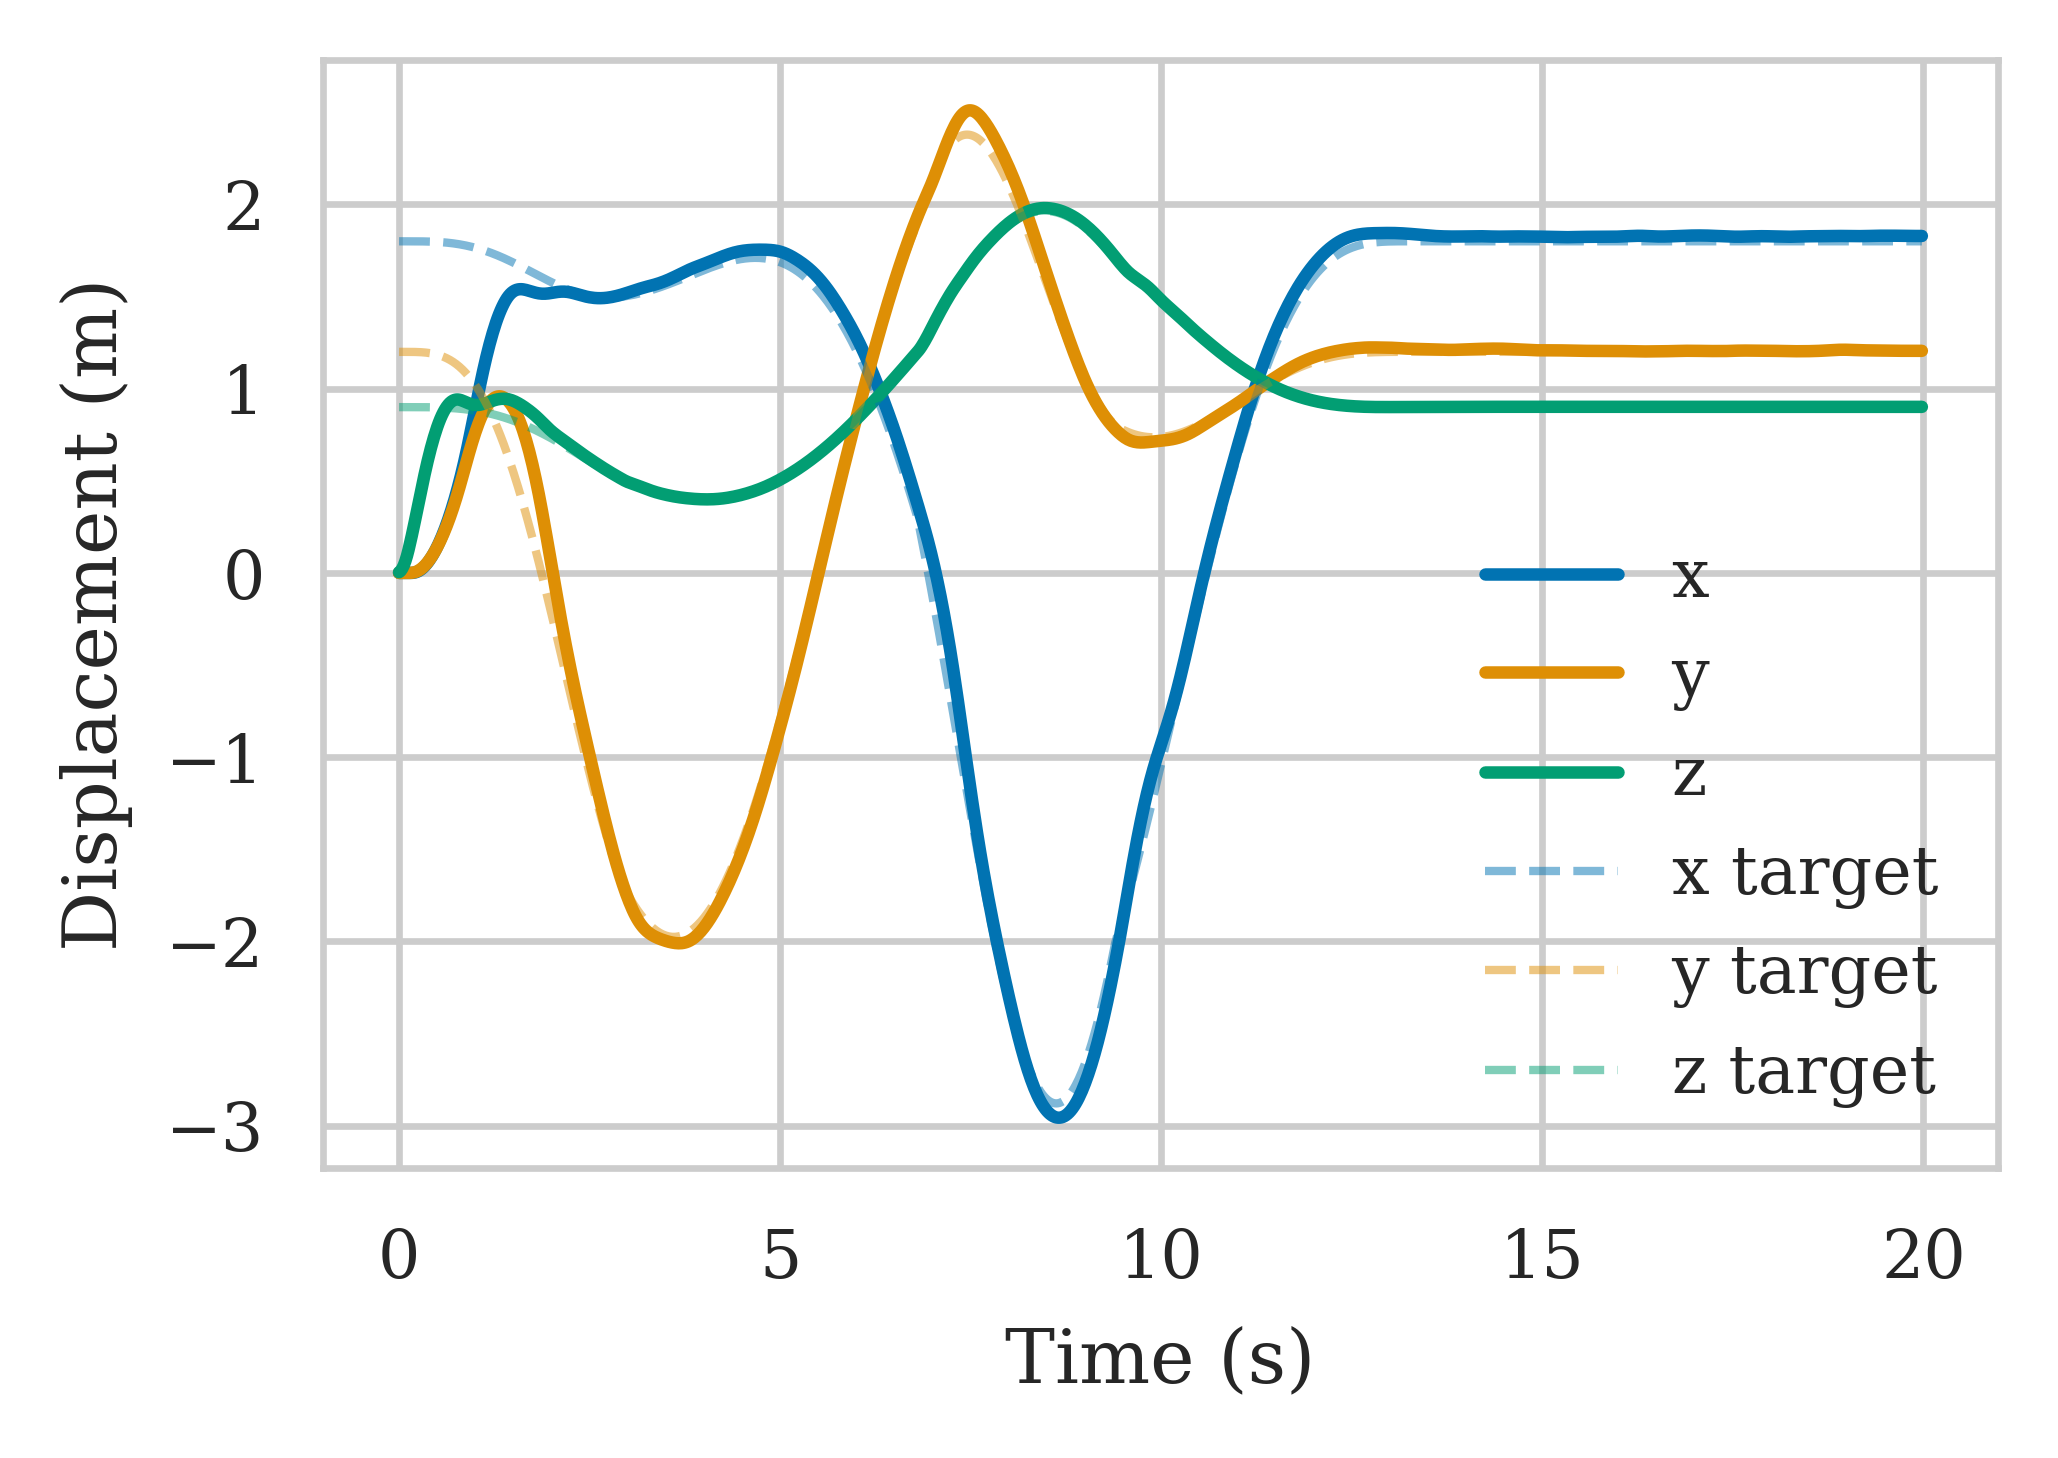

In [ ]:
timestamps = timestamps.squeeze()
x = states[0, 0, :]
y = states[0, 1, :]
z = states[0, 2, :]

x_target = controls[0, 0, :]
y_target = controls[0, 1, :]
z_target = controls[0, 2, :]

# Define your Seaborn style and a color palette with three distinct colors
sns.set_style('whitegrid')
palette = sns.color_palette('colorblind', 3)

# Update matplotlib parameters for the publication-quality plot
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.dpi': 600
})

fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot each state using the assigned palette color
ax.plot(timestamps, x, label='x', color=palette[0])
ax.plot(timestamps, y, label='y', color=palette[1])
ax.plot(timestamps, z, label='z', color=palette[2])

# Plot the corresponding target states with the same color but increased transparency and dashed lines
ax.plot(timestamps, x_target, label='x target', linestyle='--', color=palette[0], alpha=0.5, linewidth=1)
ax.plot(timestamps, y_target, label='y target', linestyle='--', color=palette[1], alpha=0.5, linewidth=1)
ax.plot(timestamps, z_target, label='z target', linestyle='--', color=palette[2], alpha=0.5, linewidth=1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (m)')
ax.legend(loc='best', frameon=False)

plt.tight_layout()
plt.savefig('pid_trajectory_tracking.png', dpi=600)
plt.show()


In [4]:
def run(
        drone=DEFAULT_DRONES,
        num_drones=DEFAULT_NUM_DRONES,
        physics=DEFAULT_PHYSICS,
        gui=DEFAULT_GUI,
        record_video=DEFAULT_RECORD_VISION,
        plot=DEFAULT_PLOT,
        user_debug_gui=DEFAULT_USER_DEBUG_GUI,
        obstacles=DEFAULT_OBSTACLES,
        simulation_freq_hz=DEFAULT_SIMULATION_FREQ_HZ,
        control_freq_hz=DEFAULT_CONTROL_FREQ_HZ,
        duration_sec=DEFAULT_DURATION_SEC,
        output_folder=DEFAULT_OUTPUT_FOLDER,
        colab=DEFAULT_COLAB
        ):

    INIT_XYZS = np.array([[0, 0, 0]])
    INIT_RPYS = np.array([[0, 0, 0]])

    TARGET_WAYPOINTS = np.array([[1.8, 1.2, 0.9], [1.5, -1.7, 0.5], [0.3, 1.9, 1.2], [-2, 0.8, 1.7], [1.8, 1.2, 0.9]])
    TARGET_RPY = np.array([[0, 0, 0]])

    coeff_x, coeff_y, coeff_z = get_MST_coefficients(TARGET_WAYPOINTS)
    v = 1.0

    env = CtrlAviary(drone_model=drone,
                        num_drones=num_drones,
                        initial_xyzs=INIT_XYZS,
                        initial_rpys=INIT_RPYS,
                        physics=physics,
                        neighbourhood_radius=10,
                        pyb_freq=simulation_freq_hz,
                        ctrl_freq=control_freq_hz,
                        gui=gui,
                        record=record_video,
                        obstacles=obstacles,
                        user_debug_gui=user_debug_gui
                        )
    
    #### Obtain the PyBullet Client ID from the environment ####
    PYB_CLIENT = env.getPyBulletClient()

    #### Initialize the logger ################################# TODO Make Logger update in realtime
    logger = Logger(logging_freq_hz=control_freq_hz,
                    num_drones=num_drones,
                    output_folder=output_folder,
                    colab=colab
                    )
    
    #### Initialize the controllers ############################
    if drone in [DroneModel.CF2X, DroneModel.CF2P, DroneModel.RACE]:
        ctrl = [MRAC(drone_model=drone) for i in range(num_drones)]

    
    Xm = []
    action = np.zeros((num_drones, 4))
    START = time.time()
    for i in range(0, int(duration_sec*env.CTRL_FREQ)):
        obs, reward, terminated, truncated, info = env.step(action)

        t = i/env.CTRL_FREQ
        state = generate_trajectory(t, v, TARGET_WAYPOINTS, coeff_x, coeff_y, coeff_z)

        for j in range(num_drones):
            action[j,:], _, xm = ctrl[j].computeControlFromState(control_timestep=env.CTRL_TIMESTEP,
                                                                state=obs[j],
                                                                target_pos=state.pos,
                                                                target_vel=state.vel,
                                                                target_rpy=TARGET_RPY[j, :]) # TODO Control all pos, vel, acc, yaw, yaw_dot desired states 
            
        Xm.append(xm)
            
        #### Log the simulation ####################################
        for j in range(num_drones):
            logger.log(drone=j,
                    timestamp=i/env.CTRL_FREQ,
                    state=obs[j],
                    control=np.hstack([state.pos, TARGET_RPY[j, :], np.zeros(6)])
                    )
            
        env.render()

        if gui:
            sync(i, START, env.CTRL_TIMESTEP)

    env.close()

    logger.save()
    logger.save_as_csv("min_snap")

    # if plot:
        # logger.plot()
    
    states = logger.states
    controls = logger.controls
    timestamps = logger.timestamps

    return states, controls, timestamps, np.array(Xm)
       

states, controls, timestamps, Xm = run()

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
viewMatrix (0.9396926760673523, 0.0, 0.3420201241970062, 0.0, 0.3420201241970062, 0.0, -0.9396926760673523, 0.0, -0.0, 1.0000001192092896, -0.0, 0.0, -9.646061016610474e-08, -0.0, -13.000000953674316, 1.0)
projectionMatrix (0.72265625, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0000200271606445, -1.0, 0.0, 0.0, -0.02000020071864128, 0.0)

[INFO] BaseAviary.render() ——— it 0001 —

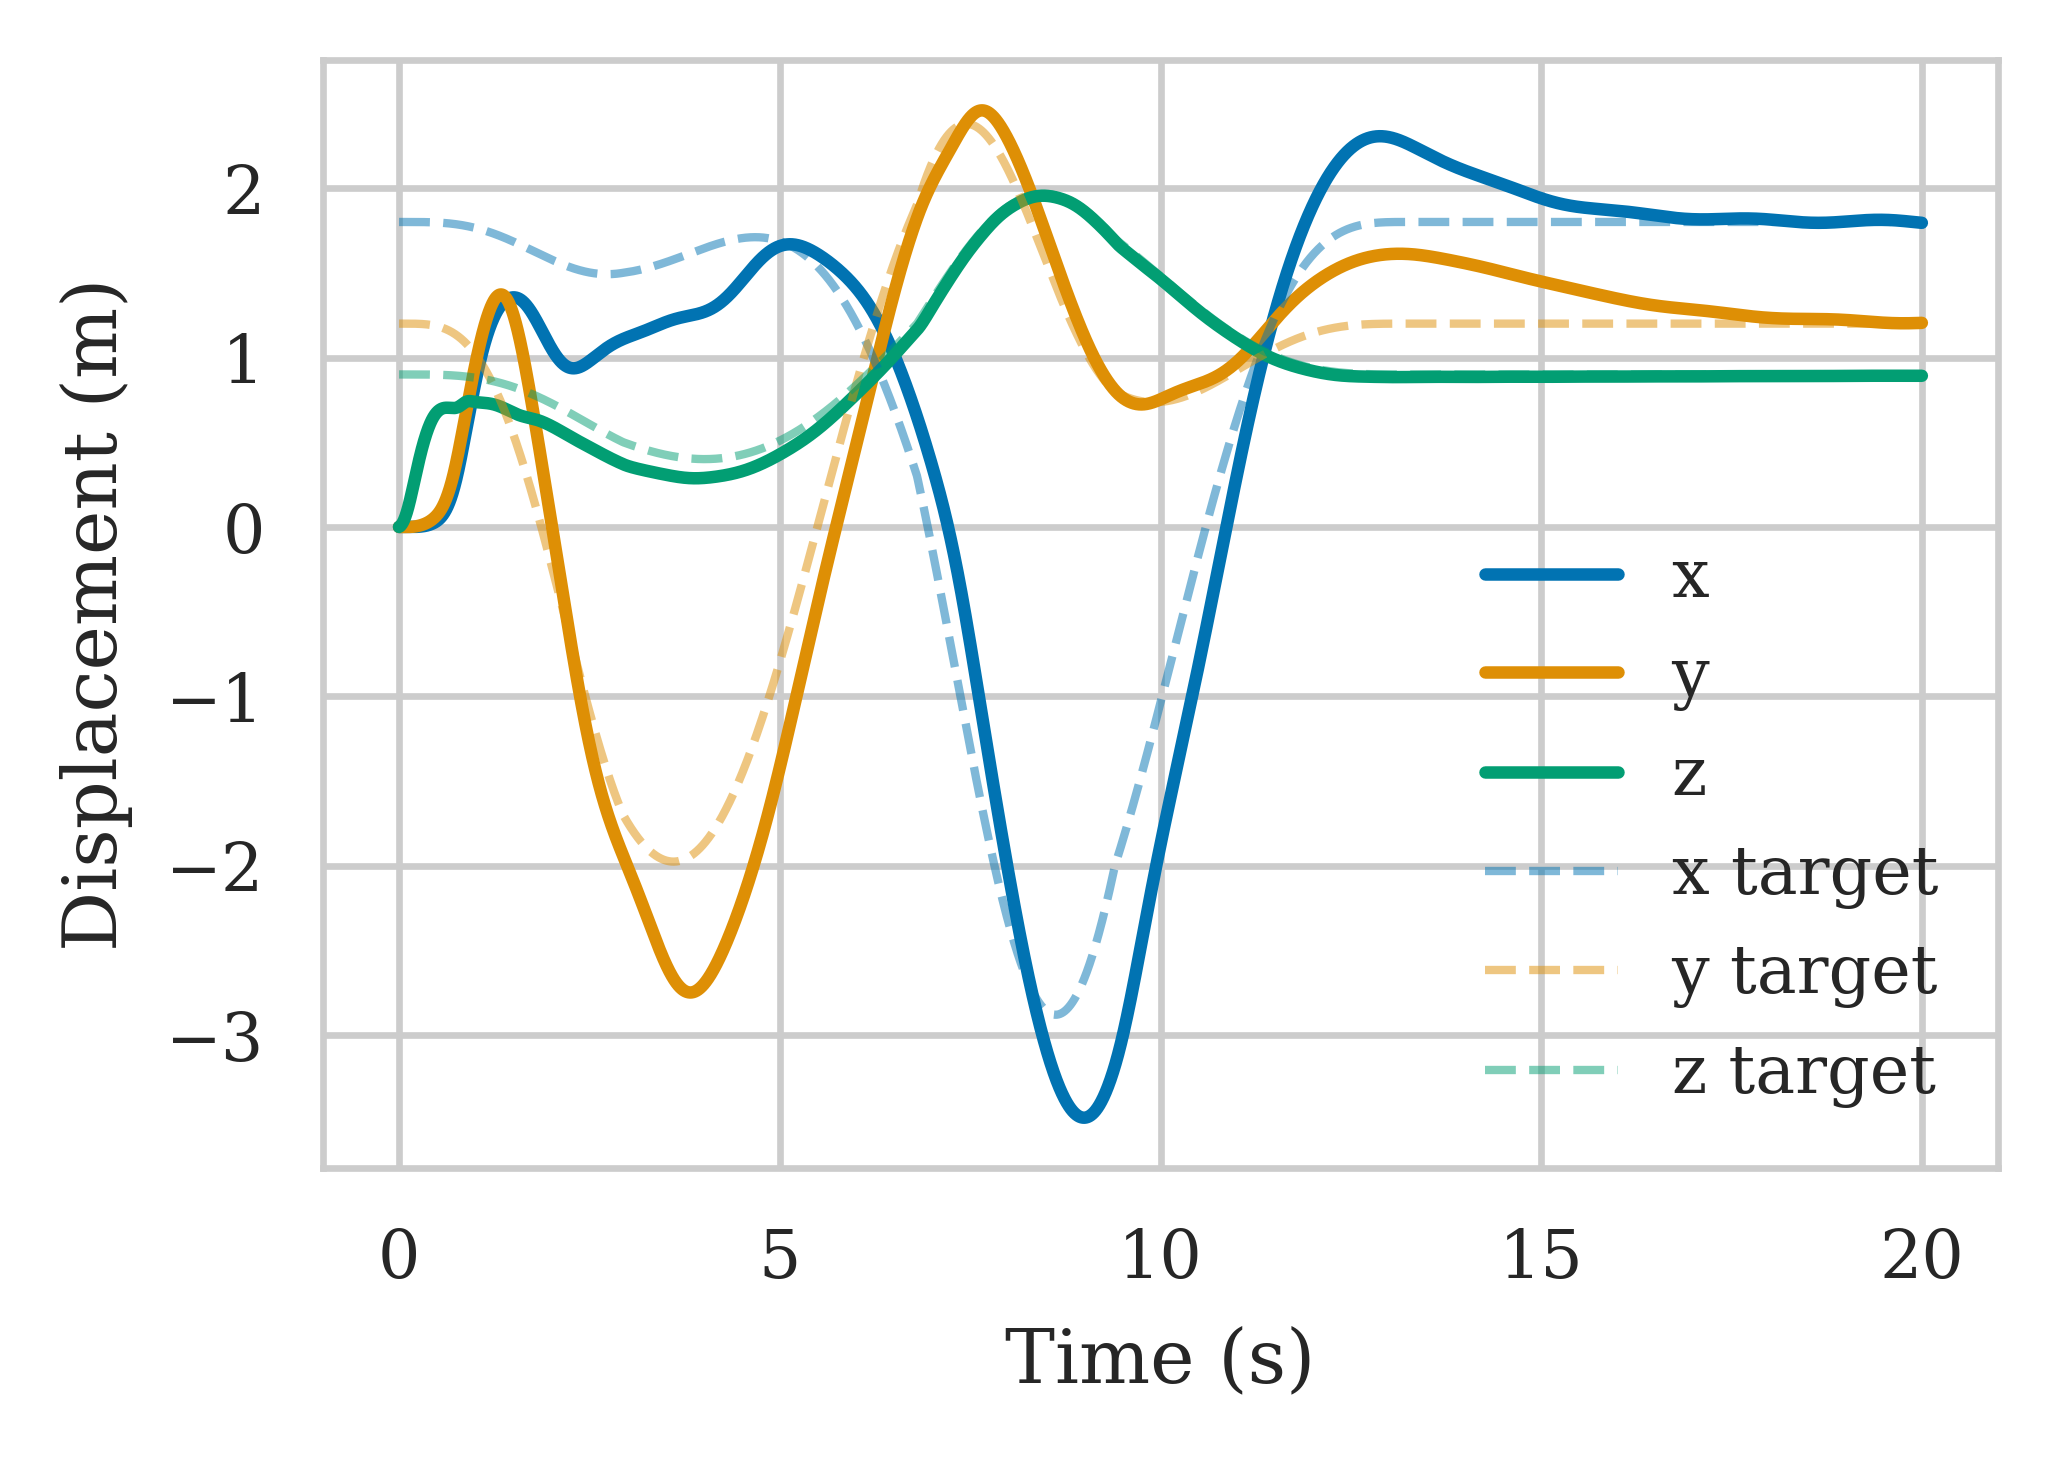

In [5]:
timestamps = timestamps.squeeze()
x = states[0, 0, :]
y = states[0, 1, :]
z = states[0, 2, :]

x_target = controls[0, 0, :]
y_target = controls[0, 1, :]
z_target = controls[0, 2, :]

# Define your Seaborn style and a color palette with three distinct colors
sns.set_style('whitegrid')
palette = sns.color_palette('colorblind', 3)

# Update matplotlib parameters for the publication-quality plot
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.dpi': 600
})

fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot each state using the assigned palette color
ax.plot(timestamps, x, label='x', color=palette[0])
ax.plot(timestamps, y, label='y', color=palette[1])
ax.plot(timestamps, z, label='z', color=palette[2])

# Plot the corresponding target states with the same color but increased transparency and dashed lines
ax.plot(timestamps, x_target, label='x target', linestyle='--', color=palette[0], alpha=0.5, linewidth=1)
ax.plot(timestamps, y_target, label='y target', linestyle='--', color=palette[1], alpha=0.5, linewidth=1)
ax.plot(timestamps, z_target, label='z target', linestyle='--', color=palette[2], alpha=0.5, linewidth=1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (m)')
ax.legend(loc='best', frameon=False)

plt.tight_layout()
plt.savefig('mrac_trajectory_tracking.png', dpi=600)
plt.show()


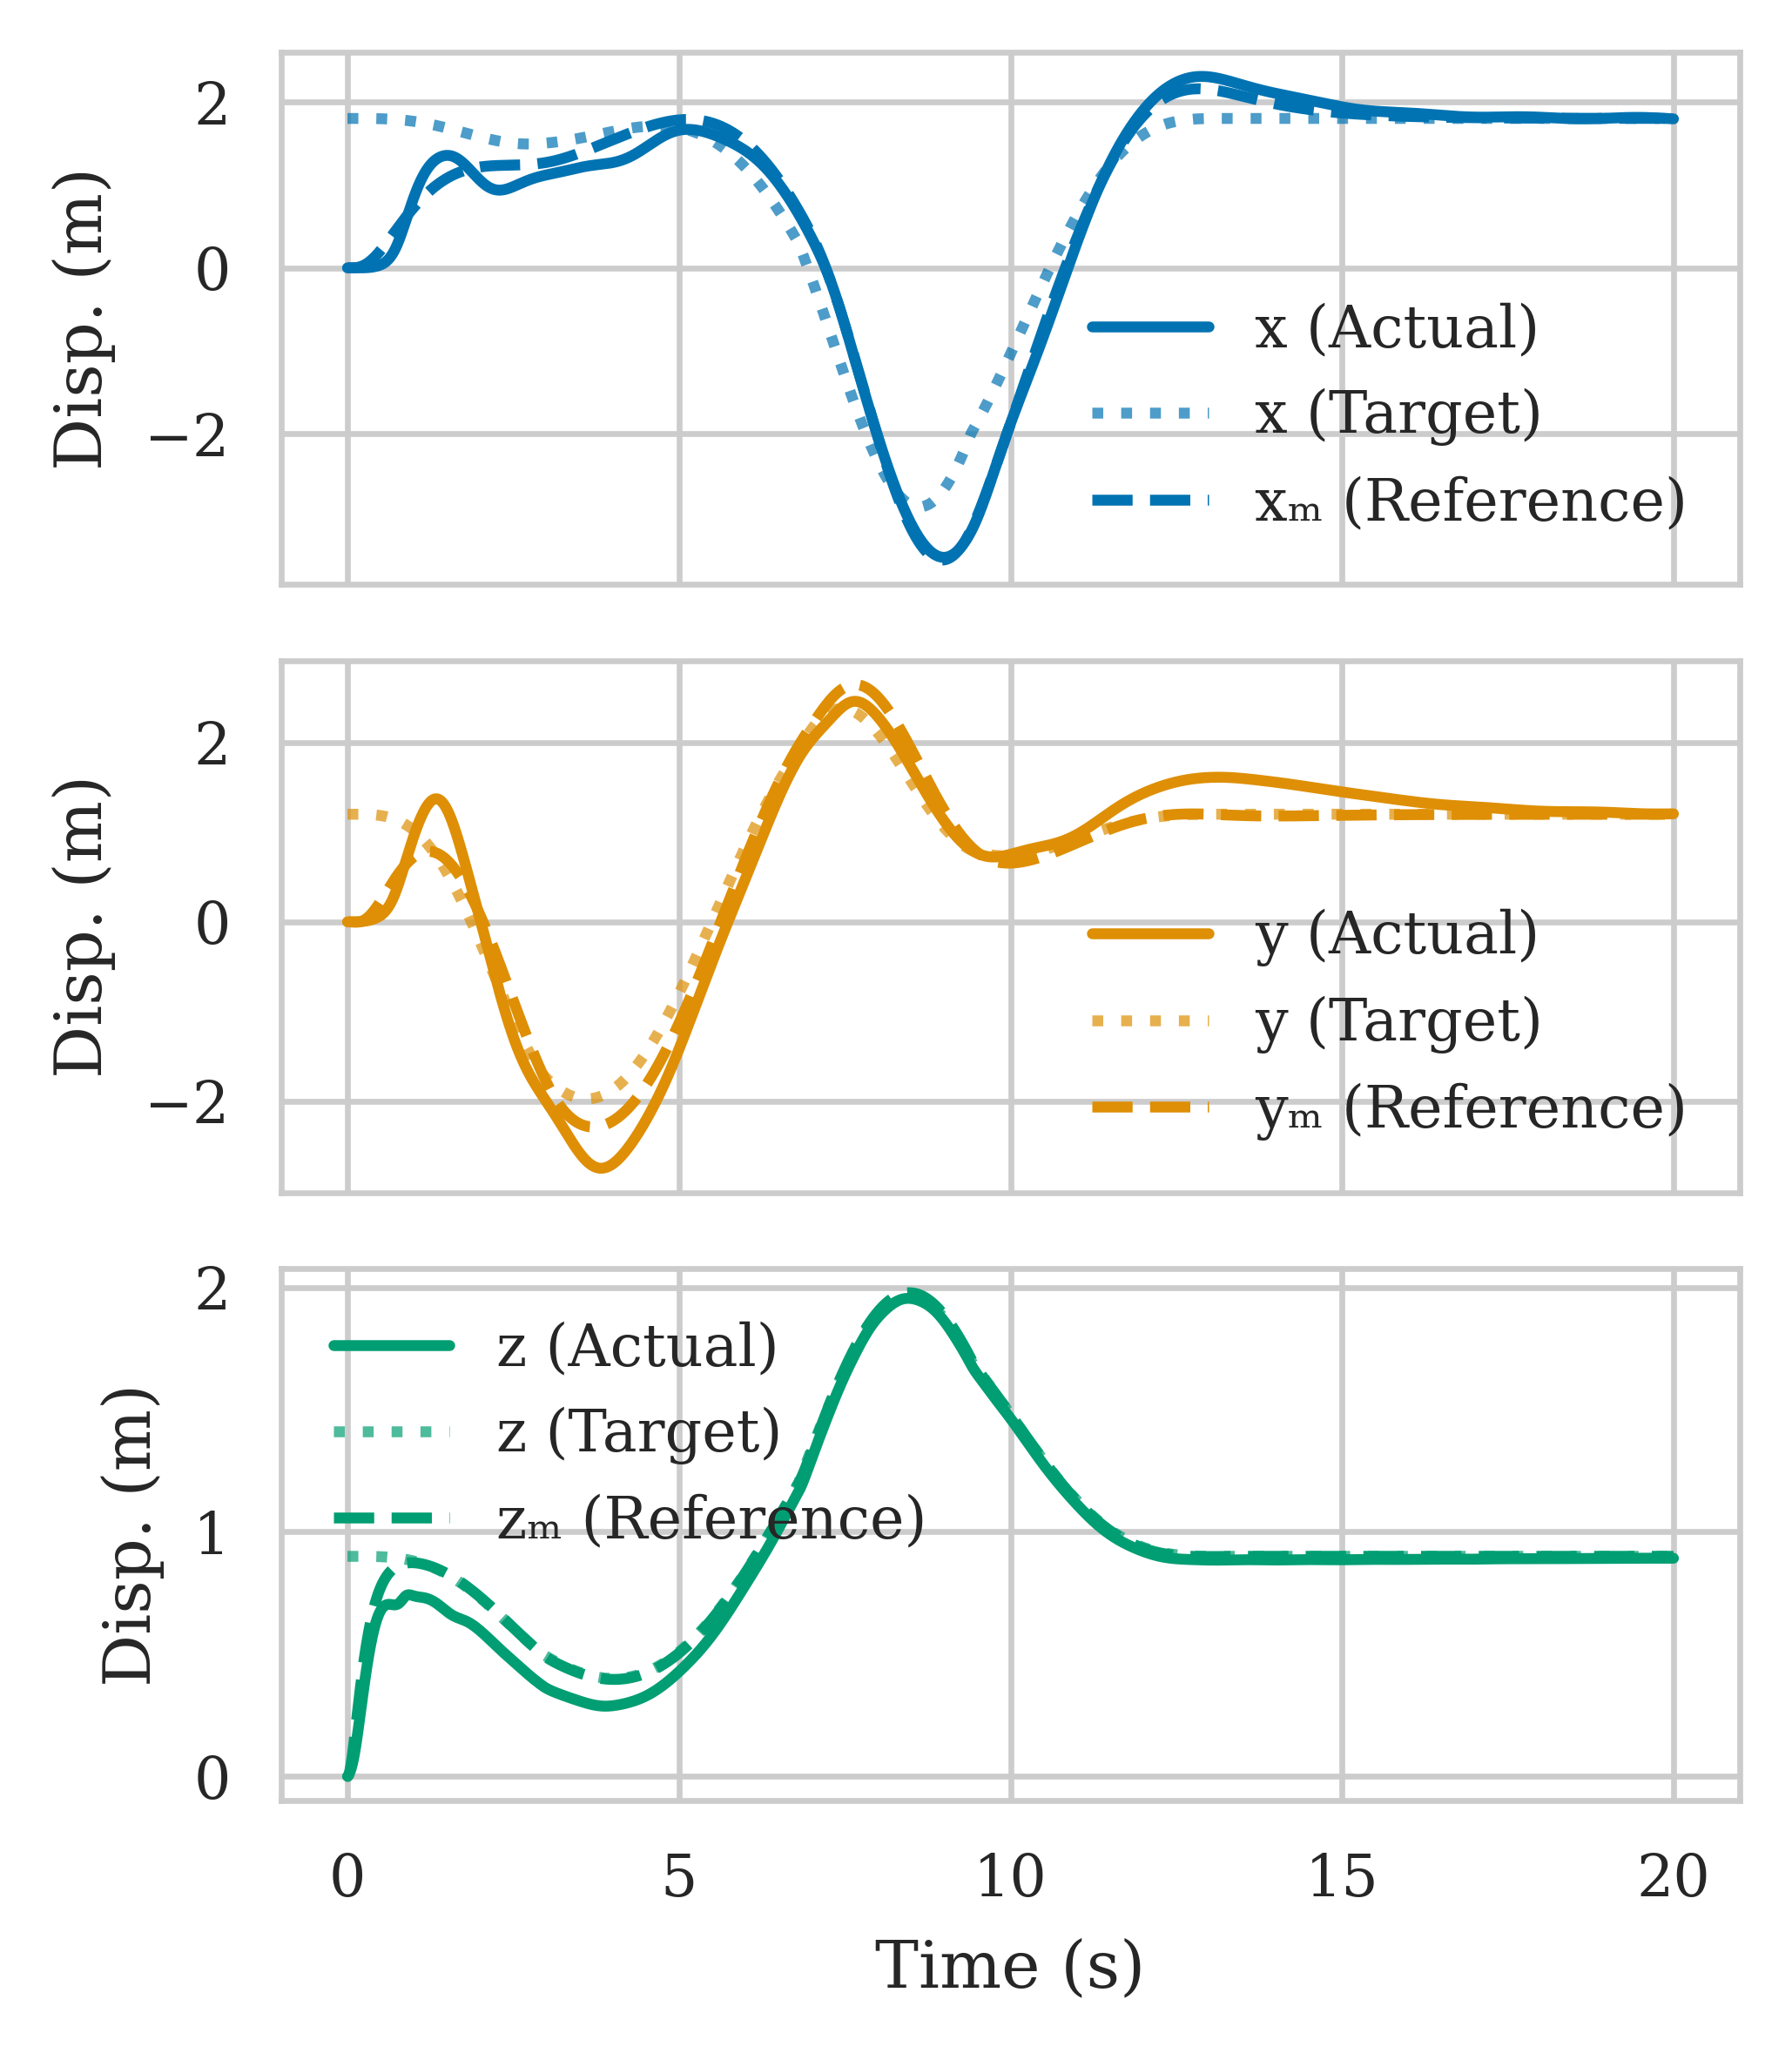

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('colorblind')

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.dpi': 600
})

# Data preparation:
timestamps = timestamps.squeeze()

# Actual states from measurements:
x = states[0, 0, :]
y = states[0, 1, :]
z = states[0, 2, :]

# Targets, defined perhaps from your control input:
x_target = controls[0, 0, :]
y_target = controls[0, 1, :]
z_target = controls[0, 2, :]

# Reference model trajectories:
xm = Xm[:, 0].squeeze()
ym = Xm[:, 1].squeeze()
zm = Xm[:, 2].squeeze()

# Prepare lists for iteration over states
labels = ['x', 'y', 'z']
actuals = [x, y, z]
targets = [x_target, y_target, z_target]
refs = [xm, ym, zm]
# Using a predefined color set (consistent with the 'colorblind' palette)
colors = ['C0', 'C1', 'C2']

# Create subplots for each state component
fig, axs = plt.subplots(3, 1, figsize=(3.5, 4), sharex=True)

for i in range(3):
    # Plot the actual state
    axs[i].plot(timestamps, actuals[i], color=colors[i],
                linestyle='-', label=f'{labels[i]} (Actual)')
    # Plot the target with a dotted line and moderate transparency
    axs[i].plot(timestamps, targets[i], color=colors[i],
                linestyle=':', alpha=0.7, label=f'{labels[i]} (Target)')
    # Plot the reference model trajectory with a dashed line
    axs[i].plot(timestamps, refs[i], color=colors[i],
                linestyle='--', label=f'{labels[i]}ₘ (Reference)')
    
    axs[i].set_ylabel('Disp. (m)')
    axs[i].legend(loc='best', frameon=False)
    
axs[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.savefig('mrac_trajectory_subplot_version.png', dpi=600)
plt.show()
